In [1]:
from collections import OrderedDict
from copy import deepcopy

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import simuPOP as sp
%matplotlib inline

simuPOP Version 1.1.6 : Copyright (c) 2004-2011 Bo Peng
Revision 4972 (May  1 2015) for Python 2.7.9 (64bit, 1thread)
Random Number Generator is set to mt19937 with random seed 0xb0a44546492df903.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


In [2]:
num_loci = 10
pop_size = 100
num_gens = 10

In [3]:
init_ops = OrderedDict()
pre_ops = OrderedDict()
post_ops = OrderedDict()

In [4]:
pops = sp.Population(pop_size, loci=[1] * num_loci)

In [5]:
init_ops['Sex'] = sp.InitSex()
init_ops['Freq'] = sp.InitGenotype(freq=[0.5, 0.5])
post_ops['Stat-freq'] = sp.Stat(alleleFreq=sp.ALL_AVAIL)
post_ops['Stat-freq-eval'] = sp.PyEval(r"'%d %.2f\n' % (gen, alleleFreq[0][0])")

In [6]:
mating_scheme = sp.RandomMating()

In [7]:
sim = sp.Simulator(pops, rep=1)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)

0 0.48
1 0.47
2 0.41
3 0.47
4 0.45
5 0.55
6 0.53
7 0.47
8 0.46
9 0.42


(10L,)

In [8]:
def init_accumulators(pop, param):
    accumulators = param
    for accumulator in accumulators:
        pop.vars()[accumulator] = []
    return True

def update_accumulator(pop, param):
    accumulator, var = param
    pop.vars()[accumulator].append(deepcopy(pop.vars()[var]))
    return True

In [9]:
def calc_exp_he(pop):
    #assuming bi-allelic markers coded as 0 and 1
    #sample size not corrected - OK
    pop.dvars().expHe = {}
    for locus, freqs in pop.dvars().alleleFreq.items():
        f0 = freqs[0]
        pop.dvars().expHe[locus] = 1 - f0**2 - (1 - f0)**2
    return True

In [10]:
init_ops['accumulators'] = sp.PyOperator(init_accumulators, param=['num_males', 'exp_he'])
post_ops['Stat-males'] = sp.Stat(numOfMales=True)
post_ops['ExpHe'] = sp.PyOperator(calc_exp_he)
post_ops['male_accumulation'] = sp.PyOperator(update_accumulator, param=('num_males', 'numOfMales'))
post_ops['expHe_accumulation'] = sp.PyOperator(update_accumulator, param=('exp_he', 'expHe'))
#remember ordering
#generation step

In [11]:
del post_ops['Stat-freq-eval']


In [12]:
num_gens = 100
pops_500 = sp.Population(500, loci=[1] * num_loci)
sim = sp.Simulator(pops_500, rep=1)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)

(100L,)

In [13]:
pop_500_after = deepcopy(sim.population(0))

In [14]:
pops_40 = sp.Population(40, loci=[1] * num_loci)
sim = sp.Simulator(pops_40, rep=1)
sim.evolve(initOps=init_ops.values(), preOps=pre_ops.values(), postOps=post_ops.values(),
           matingScheme=mating_scheme, gen=num_gens)

(100L,)

In [15]:
pop_40_after = deepcopy(sim.population(0))

In [16]:
def calc_loci_stat(var, fun):
    stat = []
    for gen_data in var:
        stat.append(fun(gen_data.values()))
    return stat

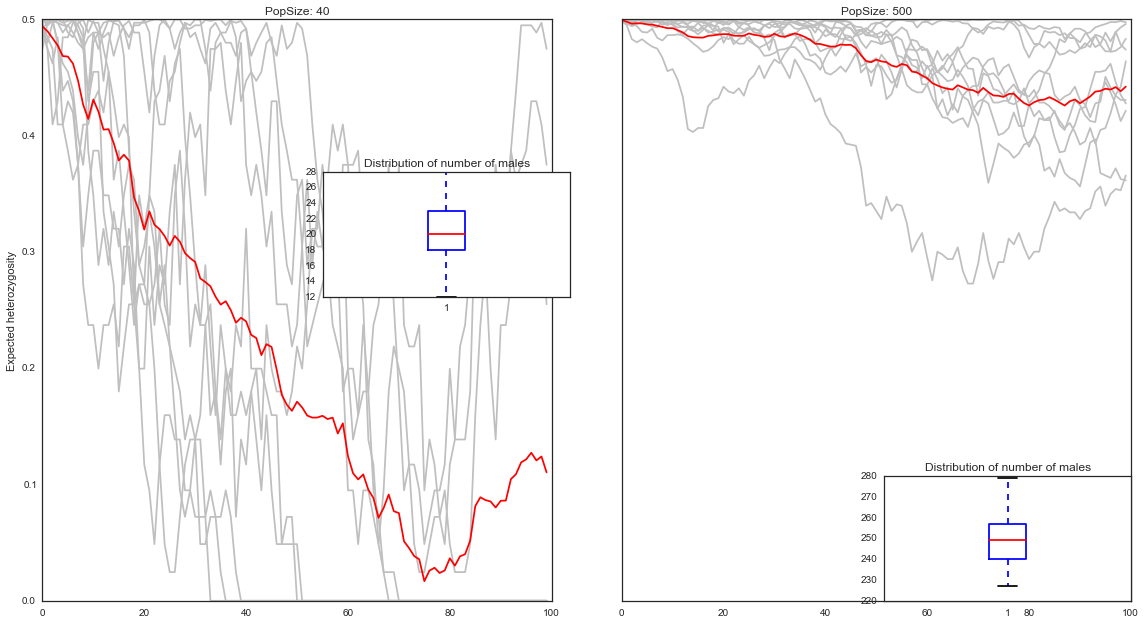

In [17]:
sns.set_style('white')
fig, axs = plt.subplots(1, 2, figsize=(16, 9), sharey=True, squeeze=False)
def plot_pop(ax1, pop):
    for locus in range(num_loci):
        ax1.plot([x[locus] for x in pop.dvars().exp_he], color=(0.75, 0.75, 0.75))
    mean_exp_he = calc_loci_stat(pop.dvars().exp_he, np.mean)
    ax1.plot(mean_exp_he, color='r')

axs[0, 0].set_title('PopSize: 40')
axs[0, 1].set_title('PopSize: 500')
axs[0, 0].set_ylabel('Expected heterozygosity')
plot_pop(axs[0, 0], pop_40_after)
plot_pop(axs[0, 1], pop_500_after)
ax = fig.add_subplot(4, 4, 6)
ax.set_title('Distribution of number of males')
ax.boxplot(pop_40_after.dvars().num_males)
ax = fig.add_subplot(4, 4, 16)
ax.set_title('Distribution of number of males')
ax.boxplot(pop_500_after.dvars().num_males)
fig.tight_layout()